In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including
the following:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per
feature
* A target key containing an array with the labels


In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it
using Matplotlib’s imshow() function

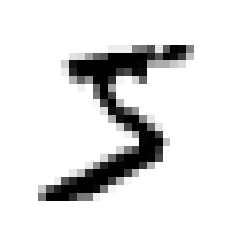

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

In [7]:
# since y is a string, and most ML algorithms expect numbers, so we will convert y to integer
y = y.astype(np.uint8)

In [8]:
y.dtype

dtype('uint8')

You should always create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
print(X_train.shape)

(60000, 784)


In [11]:
print (X_test.shape)

(10000, 784)


The training set is already shuffled for us, which is good because this guarantees that
all cross-validation folds will be similar (you don’t want one fold to be missing some
digits). Moreover, some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. Shuffling
the dataset ensures that this won’t happen.2

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task:

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient
Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s create
an SGDClassifier and train it on the whole training set:

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

the classifier predicts the correct value

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation Manually

Occasionally you will need more control over the cross-validation process than what
Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation
yourself. The following code does roughly the same thing as Scikit-Learn’s
cross_val_score() function, and it prints the same result:

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

/Users/subham/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

Let’s use the cross_val_score() function to evaluate our SGDClassifier model,
using K-fold cross-validation with three folds. Remember that K-fold cross-validation
means splitting the training set into K folds (in this case, three), then making predictions
and evaluating them on each fold using a model trained on the remaining folds

In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

let’s look at a very
dumb classifier that just classifies every single image in the “not-5” class:

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,
                scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

### Confusion Matrix

The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confusion
matrix.

To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets.

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold.

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_pred, y_train_5)

array([[53115,   916],
       [ 1464,  4505]])

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the negative
class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classified
as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right)

In [21]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions;
this is called the precision of the classifier

***precision = TP/(TP + FP)***

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since
the classifier would ignore all but one positive instance. So precision is typically used
along with another metric named ***recall***, also called ***sensitivity*** or the ***true positive rate***
(TPR): this is the ratio of positive instances that are correctly detected by the classifier

***recall = TP/(TP + FN)***<br>
FN = False Negatives

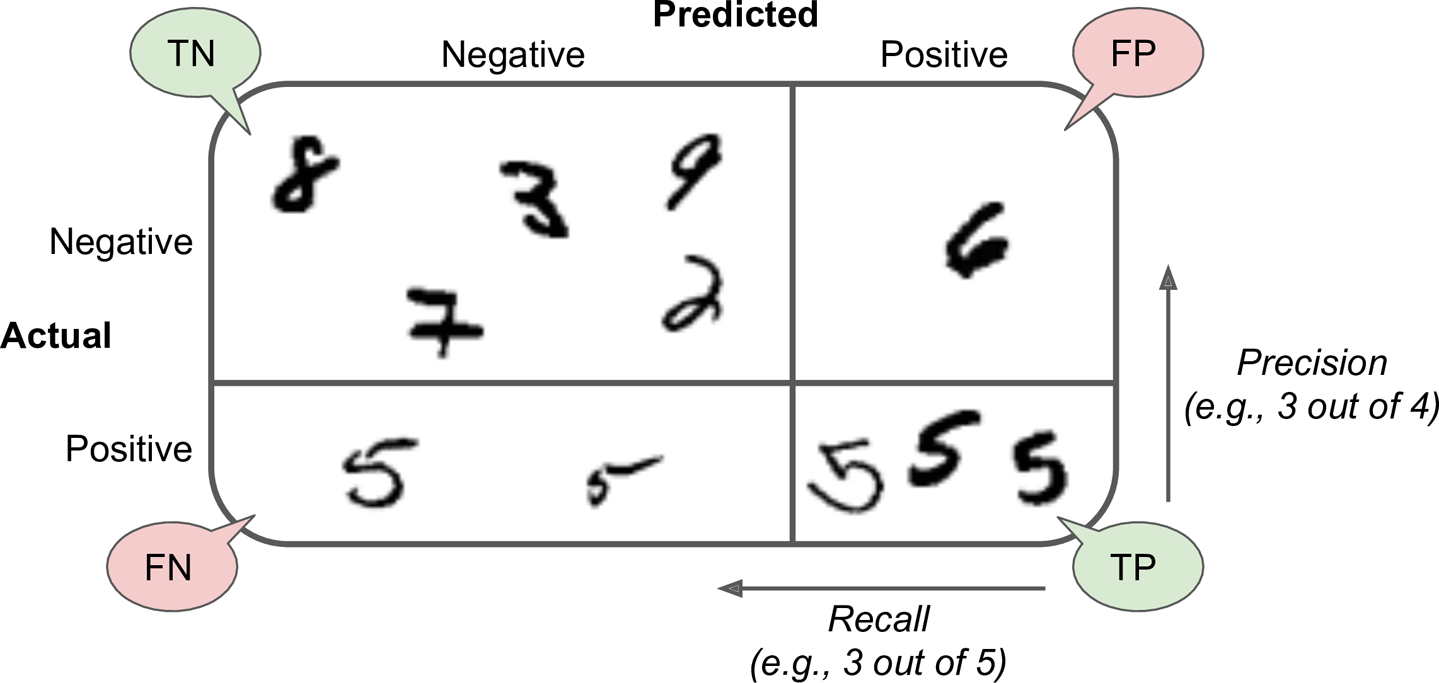

In [22]:
from sklearn.metrics import precision_score, recall_score

print (f'Precision Score: {precision_score(y_train_5, y_train_pred)}')

print (f'recall score: {recall_score(y_train_5, y_train_pred)}')

Precision Score: 0.7547327860613168
recall score: 0.8310274857037447


Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover,
it only detects 83.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the **F1 score**, in particular if you need a simple way to compare two classifiers. The F1 score is
the **harmonic mean** of precision and recall (Equation 3-3). Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high.

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.791044776119403

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall. For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection). On the other hand, suppose you train a classifier to detect
shoplifters in surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall trade-off.

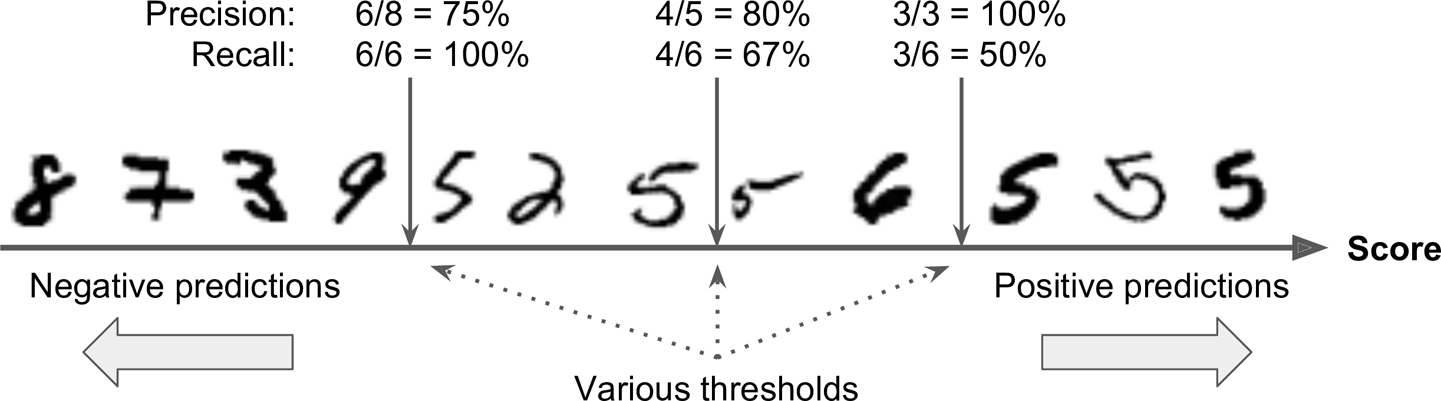

### Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification
decisions. For each instance, it computes a score based on a decision function. If
that score is greater than a threshold, it assigns the instance to the positive class;
otherwise it assigns it to the negative class.<br>
Figure shows a few digits positioned
from the lowest score on the left to the highest score on the right. Suppose the decision
threshold is positioned at the central arrow (between the two 5s): you will find 4
true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a
6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6
actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the
threshold (move it to the arrow on the right), the false positive (the 6) becomes a true
negative, thereby increasing the precision (up to 100% in this case), but one true positive
becomes a false negative, decreasing recall down to 50%. Conversely, lowering
the threshold increases recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its ***decision_function()*** method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
# The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
#result as the predict() method (i.e., True). Let’s raise the threshold:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.

How do you decide which threshold to use? First, use the ***cross_val_predict()***
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')

In [28]:
y_scores[:10]

array([  1200.93051237, -26883.79202424, -33072.03475406, -15919.5480689 ,
       -20003.53970191, -16652.87731528, -14276.86944263, -23328.13728948,
        -5172.79611432, -13873.5025381 ])

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds:

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

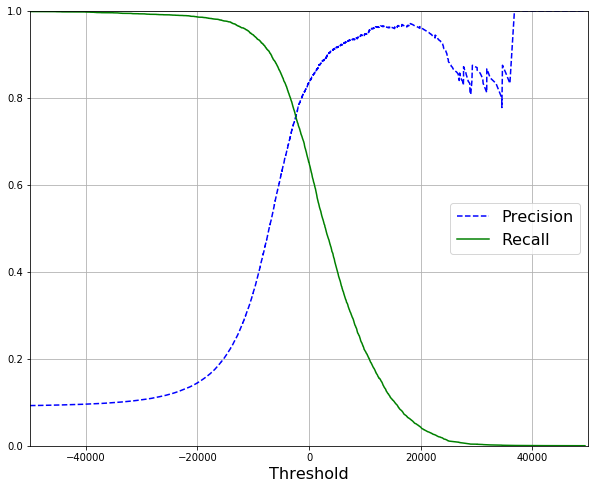

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1]) 
    
plot_precision_recall_vs_threshold(precisions, recall, thresholds)

You may wonder why the precision curve is bumpier than the recall
curve in Figure 3-4. The reason is that precision may sometimes go
down when you raise the threshold (although in general it will go
up). To understand why, look back at Figure 3-3 and notice what
happens when you start from the central threshold and move it just
one digit to the right: precision goes from 4/5 (80%) down to 3/4
(75%). On the other hand, recall can only go down when the threshold
is increased, which explains why its curve looks smooth.

Another way to select a good precision/recall trade-off is to plot precision directly
against recall, as shown in Figure (the same threshold as earlier is highlighted).

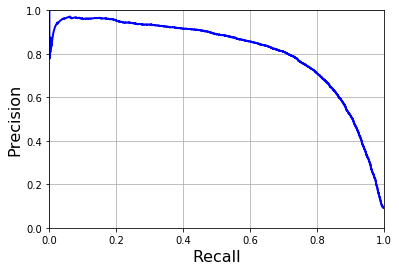

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plot_precision_vs_recall(precisions, recall)

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall trade-off just before that drop—for example,
at around 60% recall. But of course, the choice depends on your project.
Suppose you decide to aim for 90% precision. You look up the first plot and find that
you need to use a threshold of about 8,000. To be more precise you can search for the
lowest threshold that gives you at least 90% precision (np.argmax() will give you the
first index of the maximum value, which in this case means the first True value):

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. But wait, not so fast. A high-precision classifier is not very useful if its
recall is too low!

### ROC Curve

The ***receiver operating characteristic (ROC)*** curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the ***true positive rate*** (another name
for recall) against the ***false positive rate (FPR)***. The FPR is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the ***true negative rate
(TNR)***, which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called ***specificity***. Hence, the ROC curve plots ***sensitivity*** (recall) versus
***1 – specificity***.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR
and FPR for various threshold values:

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

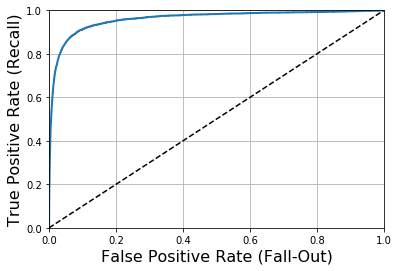

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
#     plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, linewidth= 2, label=label)
    plt.plot([0,1], [0, 1], 'k--') #dashed Diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)
plot_roc_curve(fpr, tpr)

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topleft
corner).

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC
AUC score to those of the SGDClassifier. First, you need to get scores for each
instance in the training set. But due to the way it works (see Chapter 7), the Random
ForestClassifier class does not have a decision_function() method. Instead, it has a ***predict_proba()*** method. Scikit-Learn classifiers generally have one or the
other, or both. The ***predict_proba()*** method returns **an array containing a row per
instance and a column per class, each containing the probability that the given
instance belongs to the given class** (e.g., 70% chance that the image represents a 5):

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [40]:
#The roc_curve() function expects labels and scores, but instead of scores you can
#give it class probabilities. Let’s use the positive class’s probability as the score:

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

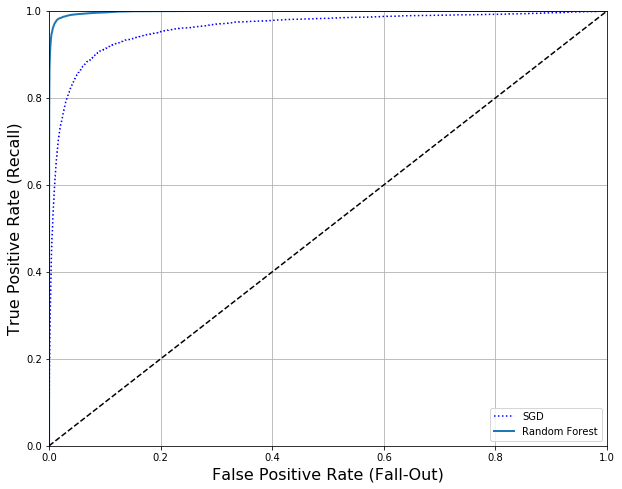

In [41]:
# now we will plot ROC curve to compare the two curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### MultiClass Classfication

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. How‐ ever, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2- detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier out‐ puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

Another strategy is to train a binary classifier for every pair of digits: one to distin‐ guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advan‐ tage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large train‐ ing sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class:

In [52]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The Highest score is indeed the one corresponding to class 5

In [57]:
np.argmax(some_digit_scores)

5

In [59]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
svm_clf.classes_[5]

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strat‐ egy, based on an SVC:

In [61]:
# from sklearn.multiclass import OneVsRestClassifier
# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# commenting out as its taking very long time to train as its training 45 Classifier

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit]

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [62]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
len(ovr_clf.estimators_)

10

if we train SGD Classifier or RandomForestClassifer Scikit-learn did not have 
to run OvR or OvO because SGD classifiers can directly classify instances 
into multiple classes

In [64]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of 2412.5. The model has a slight doubt regarding class 3, which gets a score of 573.5. Now of course you want to evaluate this classifier. As usual, you can use cross-validation. Use the cross_val_score() func‐ tion to evaluate the SGDClassifier’s accuracy:


In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scal‐ ing the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

First, look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier:

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function:

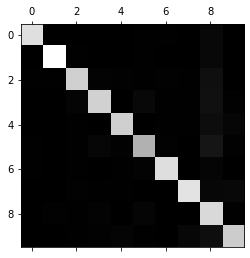

In [70]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

This confusion matrix looks pretty good, since most images are on the main diago‐ nal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

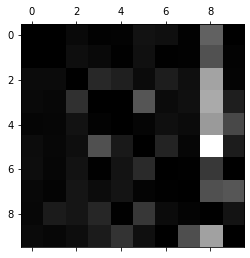

In [73]:
# fill up the diagonals with zeros to keep only the errors and plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

You can clearly see the kinds of errors the classifier makes. Remember that rows rep‐ resent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s (the plot_digits() function just uses Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details):


In [74]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [76]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

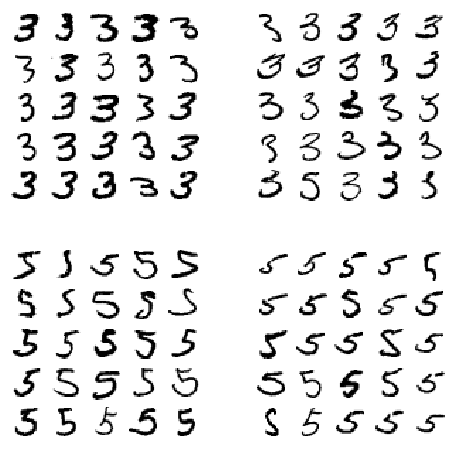

In [77]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 in the first row and second column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mis‐ takes it did.3 The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.


## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face- recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a multilabel classification system.

In [84]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, though not all classifiers do), and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [85]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average F1 score across all labels:

In [ ]:
# NOTE: This code may take hours to run
y_train_knn_pred = cross_val_prediction(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

## Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput– multiclass classification (or simply multioutput classification). It is simply a generaliza‐ tion of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐ sented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function. The target images will be the original images:


In [87]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

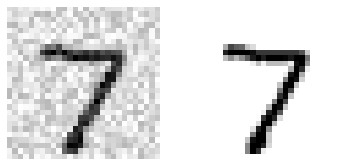

In [88]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
# plt.save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image:

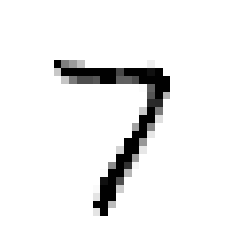

In [89]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)